<a href="https://colab.research.google.com/github/Aswath-Ram/Aswath-Ram/blob/main/trafficsign__Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LSTM, Reshape, Input, Concatenate, GlobalMaxPool2D
from keras.models import Model
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from imgaug import augmenters as aa 
import cv2
import random


This is the signs classification code

In [4]:
#loading dataset from the drive
#dataset used here is the german Traffic sign dataset, with 43 classes 
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
train_file = "/content/drive/My Drive/traffic_Sign_501/train.p"
valid_file= "/content/drive/My Drive/traffic_Sign_501/valid.p"
test_file = "/content/drive/My Drive/traffic_Sign_501/test.p"
with open(train_file, mode='rb') as f:
    train = pkl.load(f)
with open(valid_file, mode='rb') as f:
    valid = pkl.load(f)
with open(test_file, mode='rb') as f:
    test = pkl.load(f)
WIDTH = 32
HEIGHT = 32


In [10]:
X_train = train['features']
Y_train = train['labels']
print('features shape:',X_train.shape)
print('Labels:',Y_train.shape)

features shape: (34799, 32, 32, 3)
Labels: (34799,)


In [11]:
X_valid = valid['features']
y_valid = valid['labels']

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

print(X_valid.shape)
print(y_valid.shape)

(4410, 32, 32, 3)
(4410,)


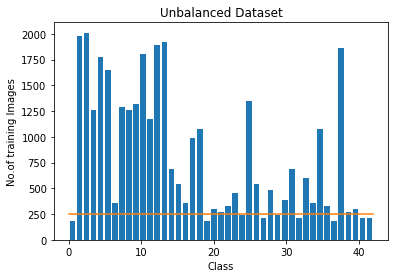

In [15]:
num_bins = 43
samples_per_bin = 250
plt.hist(Y_train, bins =num_bins,rwidth=0.8)
plt.plot((np.min(Y_train), np.max(Y_train)), (samples_per_bin, samples_per_bin))
plt.title('Unbalanced Dataset')
plt.xlabel('Class')
plt.ylabel('No.of training Images')
plt.show()

_, bins = np.histogram(Y_train, num_bins)

In [25]:
#Data has to be balanced before training 
print ('total data:', len(X_train))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(Y_train)):
    if Y_train[i]>= bins[j] and Y_train[i]<=bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  #print(list_)
  if len(list_)>samples_per_bin:
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))

X_train = np.delete(X_train, remove_list, axis=0)
print ('remaining images:', len (X_train))

Y_train = np.delete(Y_train, remove_list, axis=0)
print ('remaining labels:', len (Y_train))

total data: 10360
removed: 0
remaining images: 10360
remaining labels: 10360


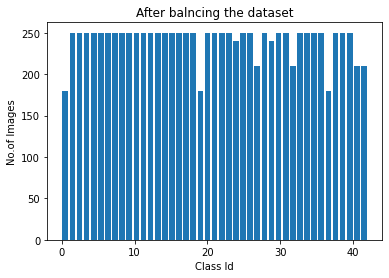

In [26]:
num_bins = 43
samples_per_bin = 500
plt.hist(Y_train, bins =num_bins,rwidth=0.8)
plt.title('After balncing the dataset')
plt.xlabel('Class Id')
plt.ylabel('No.of Images')
plt.show()

In [27]:
#image augmentation and dataset augmentation("taking care of the intensity mismatch in image part, zooming effect")
def zoom(image):
  zoom_img = aa.Affine(scale = (0.9, 1.3))
  image = zoom_img.augment_image(image)
  return image

37


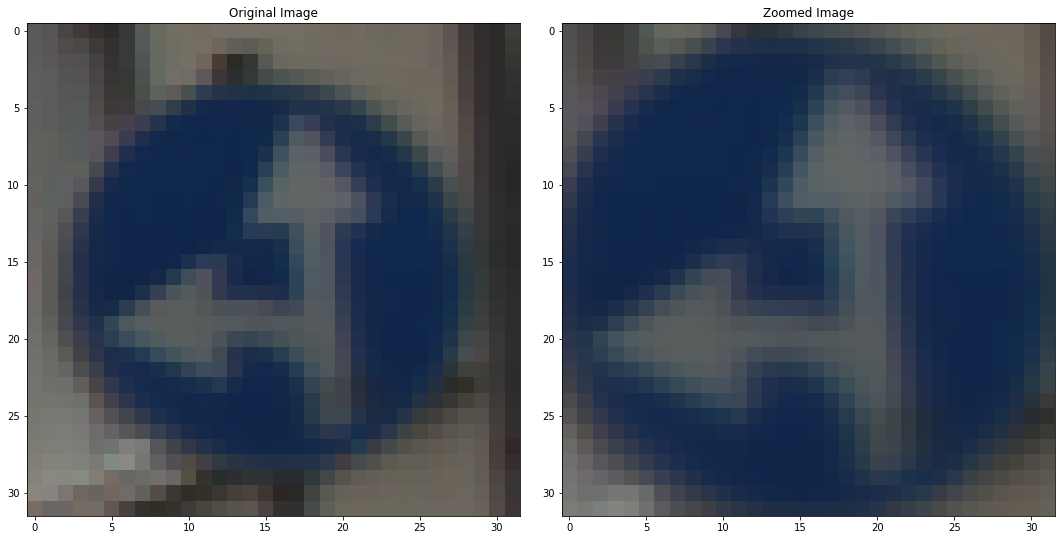

In [28]:
index = random.randint(0,len(X_train)-1)
image= X_train[index]
label= Y_train [index]
zoomed_image = zoom(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

print(label)

In [29]:
def pan(image):
  pan = aa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

24


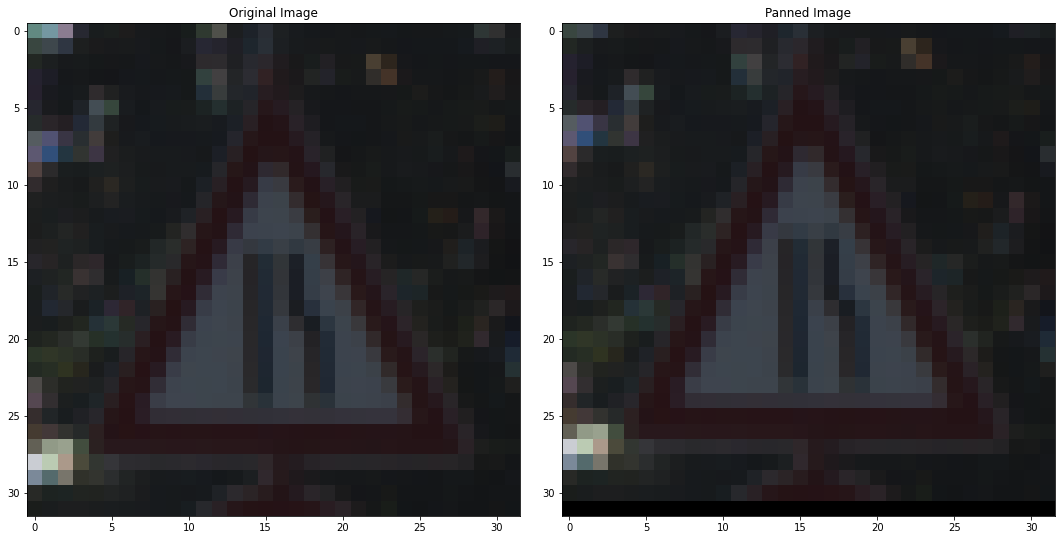

In [31]:
index = random.randint(0,len(X_train)-1)
image= X_train[index]
label= Y_train [index]
panned_image = pan(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

print(label)

In [32]:
def img_random_brightness(image):
  brightness = aa.Multiply((0.2, 1.8))
  image = brightness.augment_image(image)
  return image

In [34]:
augmented_zoom_image = []
augmented_zoom_label = []

for i in range(len(Y_train)):
  img = X_train[i]
  label = Y_train[i]
  zoomed_img = zoom(img)
  augmented_zoom_image.append(zoomed_img)
  augmented_zoom_label.append(label)


In [35]:
augmented_pan_image = []
augmented_pan_label = []

for i in range(len(Y_train)):
  img = X_train[i]
  label = Y_train[i]
  panned_img = pan(img)
  augmented_pan_image.append(panned_img)
  augmented_pan_label.append(label)

In [37]:
augmented_bright_image = []
augmented_bright_label = []

for i in range(len(Y_train)):
  img = X_train[i]
  label = Y_train[i]
  bright_img = img_random_brightness(img)
  augmented_bright_image.append(bright_img)
  augmented_bright_label.append(label)

In [38]:
print(' Before Augmentation(Image):', X_train.shape)
print(' Before Augmentation(Label):', Y_train.shape)
#change to np array
augmented_zoom_image = np.array(augmented_zoom_image)
augmented_pan_image = np.array(augmented_pan_image)
augmented_bright_image = np.array(augmented_bright_image)
X_train = np.array(X_train)
#concatenate
X_train = np.concatenate((X_train, augmented_zoom_image, augmented_pan_image, augmented_bright_image))


#change to np array
augmented_zoom_label = np.array(augmented_zoom_label) #250
augmented_pan_label = np.array(augmented_pan_label) #250
augmented_bright_label = np.array(augmented_bright_label) #250
Y_train = np.array(Y_train) #250
#concatenate
Y_train = np.concatenate((Y_train, augmented_zoom_label, augmented_pan_label, augmented_bright_label))

print(' After Augmentation(Image):', X_train.shape)
print(' After Augmentation(Label):', Y_train.shape)

 Before Augmentation(Image): (10360, 32, 32, 3)
 Before Augmentation(Label): (10360,)
 After Augmentation(Image): (41440, 32, 32, 3)
 After Augmentation(Label): (41440,)


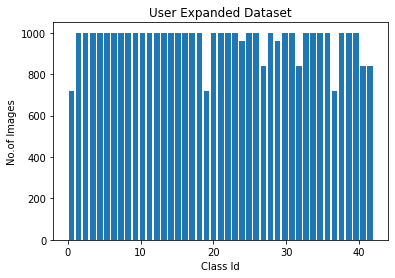

In [39]:
num_bins = 43
plt.hist(Y_train, bins =num_bins,rwidth=0.8)
plt.title('User Expanded Dataset')
plt.xlabel('Class Id')
plt.ylabel('No.of Images')
plt.show()

In [41]:
def CNN_Model():
  model = Sequential()

  #1st layer
  model.add(Conv2D(24, kernel_size=(5,5), strides=(1,1), input_shape=(WIDTH, HEIGHT,3), activation='relu'))

  #2nd layer
  model.add(Conv2D(36, kernel_size=(5,5), strides=(1,1), activation='relu'))

  #3rd layer
  model.add(Conv2D(48, kernel_size=(5,5), strides=(1,1), activation='relu'))
  
  #4th layer
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))

  #5th layer
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))


  #1st Dense Layer
  model.add(Flatten())
  model.add(Dense(250, activation='relu'))
  #model.add(Dropout(0.5))

  #2nd Dense Layer
  model.add(Dense(125, activation='relu'))
  #model.add(Dropout(0.5))

  #3rd Dense Layer
  model.add(Dense(75, activation='relu'))
  #model.add(Dropout(0.5))

  #output
  model.add(Dense(43, activation='softmax'))
  
  #Compile model
  model.compile(Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [42]:
model = CNN_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 48)        43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 250)               4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [43]:
def labels_to_one_hot(y_labels, num_classes):
  matrix_eye = np.eye(num_classes)
  y_labels_array = []
  for i in range(len(y_labels)):
    y_labels_array.append(matrix_eye[:,y_labels[i]])
  return np.array(y_labels_array)

In [45]:
y_train = labels_to_one_hot(Y_train, 43)
y_valid = labels_to_one_hot(y_valid, 43)

print(y_train.shape)
print(y_valid.shape)

(41440, 43)
(4410, 43)


In [46]:
history = model.fit(x=X_train, y=y_train, 
                    batch_size=32, 
                    epochs=10, 
                    verbose=1, 
                    validation_data=(X_valid, y_valid), 
                    shuffle=True)

Epoch 1/10
1295/1295 [==============================] - 52s 7ms/step - loss: 1.9483 - accuracy: 0.5529 - val_loss: 0.4015 - val_accuracy: 0.9161
Epoch 2/10
1295/1295 [==============================] - 8s 7ms/step - loss: 0.3038 - accuracy: 0.9318 - val_loss: 0.3157 - val_accuracy: 0.9263
Epoch 3/10
1295/1295 [==============================] - 8s 6ms/step - loss: 0.1309 - accuracy: 0.9692 - val_loss: 0.1784 - val_accuracy: 0.9633
Epoch 4/10
1295/1295 [==============================] - 8s 6ms/step - loss: 0.0812 - accuracy: 0.9805 - val_loss: 0.3473 - val_accuracy: 0.9558
Epoch 5/10
1295/1295 [==============================] - 9s 7ms/step - loss: 0.0740 - accuracy: 0.9842 - val_loss: 0.2691 - val_accuracy: 0.9512
Epoch 6/10
1295/1295 [==============================] - 8s 6ms/step - loss: 0.0474 - accuracy: 0.9886 - val_loss: 0.1904 - val_accuracy: 0.9635
Epoch 7/10
1295/1295 [==============================] - 9s 7ms/step - loss: 0.0333 - accuracy: 0.9916 - val_loss: 0.1576 - val_accuracy

Text(0.5, 0, 'epoch')

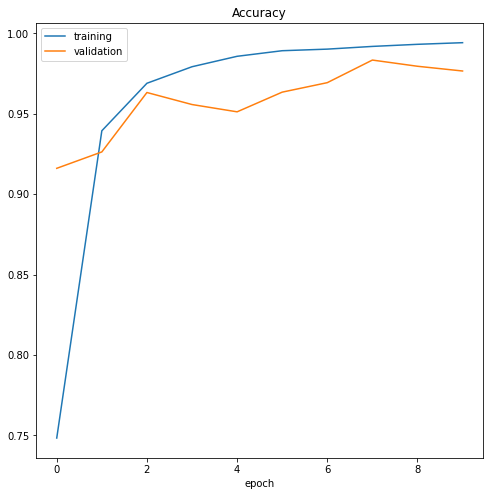

In [47]:
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

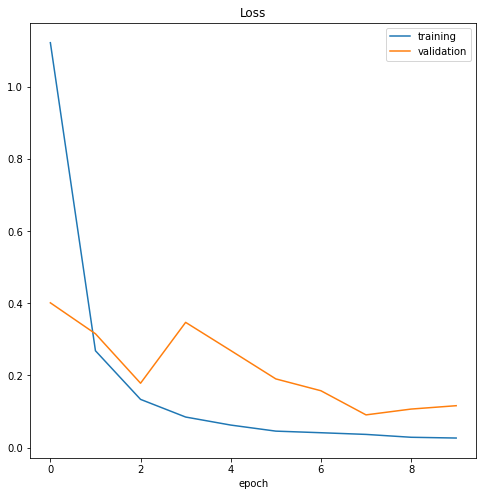

In [48]:
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

In [49]:
X_test = test['features']
y_test = test['labels']

X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(12630, 32, 32, 3)
(12630,)


In [50]:
y_test = labels_to_one_hot(y_test, 43)


Actual:  4
Prediction:  4


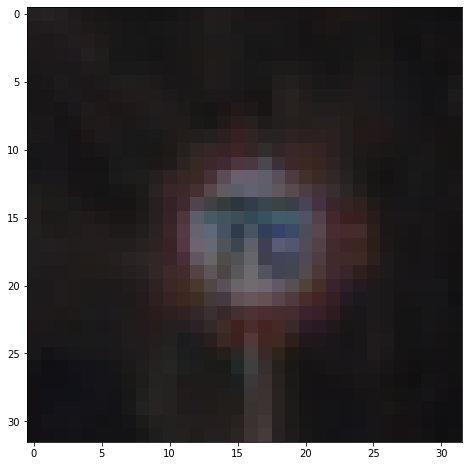

In [51]:
index = random.randint(0,len(X_test)-1)
img_testing = X_test[index]
label_testing = y_test[index]

plt.imshow(img_testing)
print ("Actual: ", np.argmax(label_testing))
img_testing = img_testing.reshape(-1, WIDTH,HEIGHT,3)

print ("Prediction: ", np.argmax(model.predict(img_testing)))

In [52]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
395/395 [==============================] - 1s 4ms/step - loss: 0.3282 - accuracy: 0.9465
test loss, test acc: [0.3281608819961548, 0.9464766383171082]


In [54]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [55]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [56]:
model.save('Traffic_classify.h5')    
model_file = drive.CreateFile({'title' : 'Traffic_classify.h5'})
model_file.SetContentFile('Traffic_classify.h5')
model_file.Upload()

In [57]:
drive.CreateFile({'id': model_file.get('id')})


GoogleDriveFile({'id': '1cvF1vCf1SJOPxDLlLHOrkYEOg_2yoyHL'})

In [53]:
model.save('traffic_Classify.h5')